In [1]:
from scipy.optimize import minimize
import seaborn as sns
import pylab as plt
import numpy as np
import pandas as pd
import plot_functions as plotf
import bootstrap_functions as bootf
import model_functions as modelf
import read_experimental_data as e_data

sns.set_context('notebook', font_scale=1.7, rc={'lines.linewidth': 1.3, 'axes.facecolor': 'white'})
np.random.seed(0)
%matplotlib inline

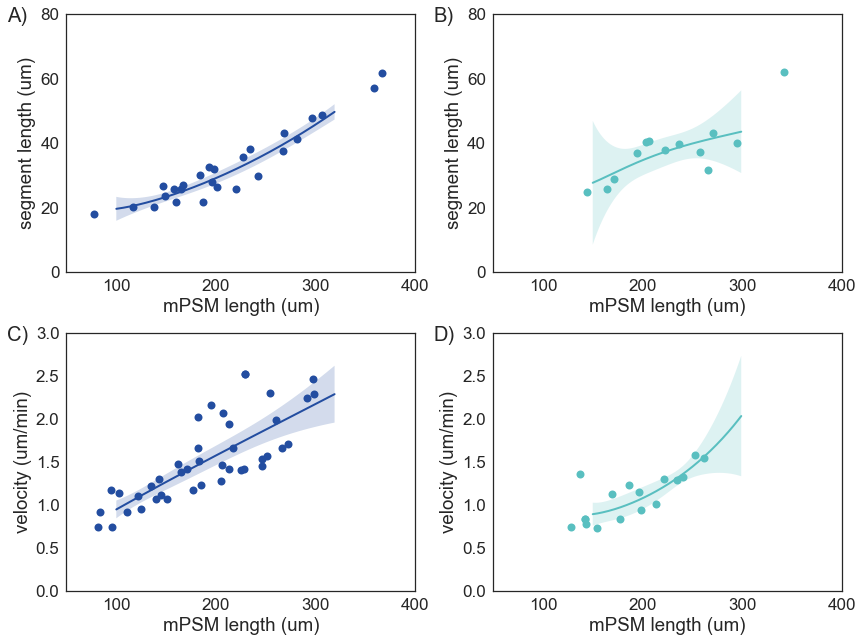

In [2]:
# Obtaining experimental data from Lauschke et al 2013 for temperatures 37 and 33 C
d37, d33 = e_data.readData_Lauschke2013()

# range of the mPSM
d37['rPSM'] = np.arange(100, 320, 1)
d33['rPSM'] = np.arange(150, 300, 1)

# getting and plotting a boostrap fit of segmentation properties. 
bootf.fit_parameters(d37, npoly=2, case='ex-vivo')
bootf.fit_parameters(d33, npoly=2, case='ex-vivo')
plotf.bstrapfit(d37, d33, p=None, outx=None, params=None, case='ex-vivo')

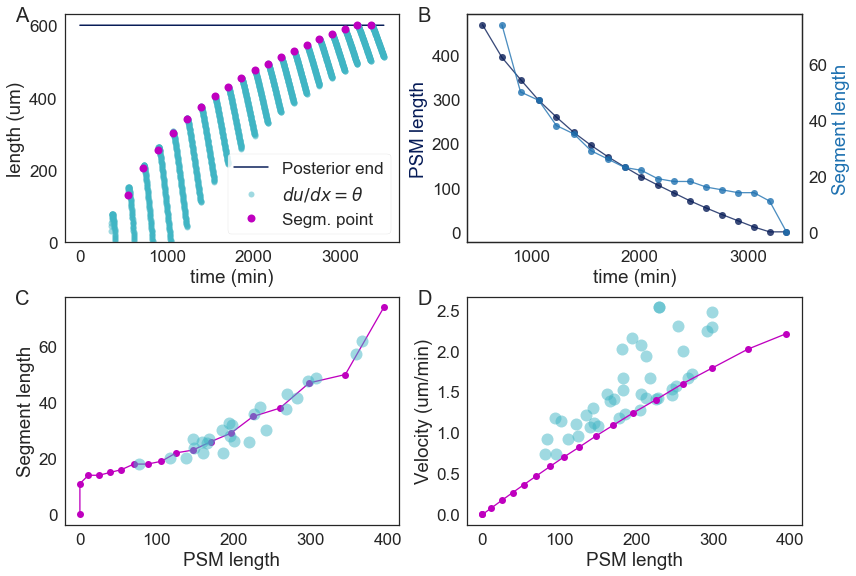

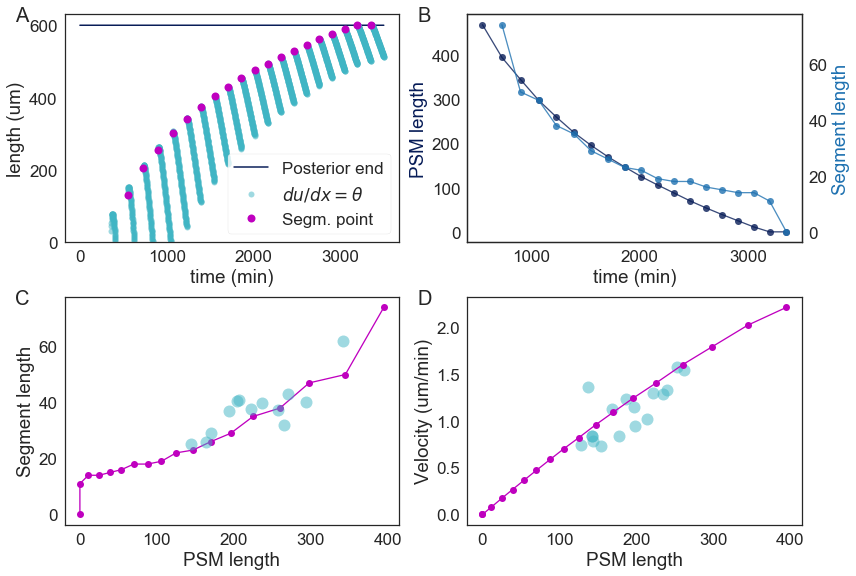

In [3]:
# starting values of the parameters
p = {}
p['a']  = 250.0
p['b']  = 2500.0
p['theta'] = 0.05
p['L0'] = 600.0
p['tr'] = np.arange(0, 3501, 1)

p['T0'] = 160.
plotf.exvivo_segmentation(d37, p)
plotf.exvivo_segmentation(d33, p)

In [4]:
# --- find the set of parameters that best fit the boostrap fit of experimental data  ----
n_sampling = 100
params = ['a', 'b', 'theta', 'T0']
xratio = [1.0, 1.0, 1.0, 1.0]
bounds = ((0.5, 2.), (0.5, 2.), (0.5, 2.), (0.5, 2.))  
x37 = np.zeros((n_sampling, len(params)))
for i in range(n_sampling):
    d37['len_m'] = d37['len_bstrap'][:,i]
    d37['vel_m'] = d37['vel_bstrap'][:,i]
    out = modelf.minimize_bstrap([d37], p, params, xratio, bounds, case='ex-vivo')
    x37[i,:] = out.x

x33 = np.zeros((n_sampling, len(params)))
for i in range(n_sampling):
    d33['len_m'] = d33['len_bstrap'][:,i]
    d33['vel_m'] = d33['vel_bstrap'][:,i]
    out = modelf.minimize_bstrap([d33], p, params, xratio, bounds, case='ex-vivo')
    x33[i,:] = out.x

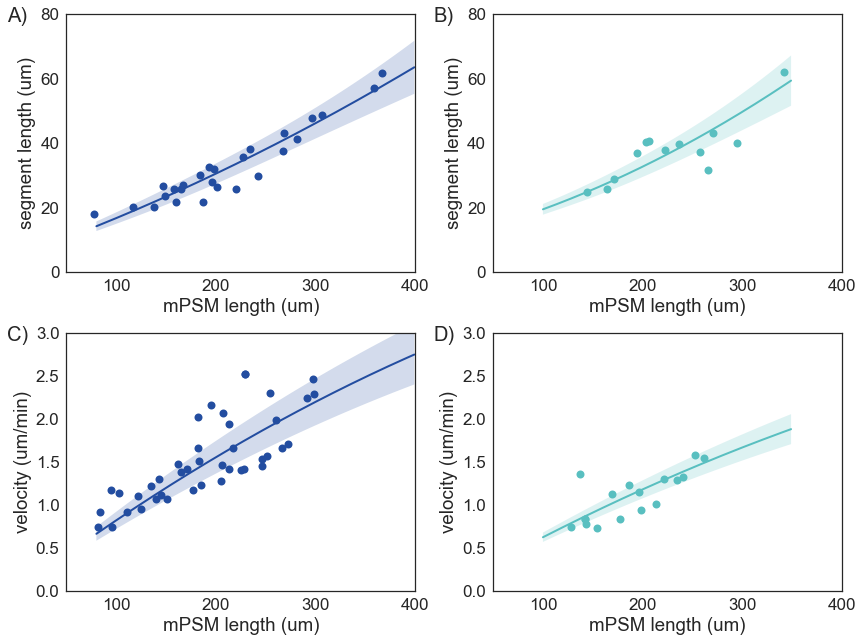

In [5]:
# defining the range of the mPSM and plotting the fit using the model
d37['rPSM'] = np.arange( 80, 400, 1)
d33['rPSM'] = np.arange(100, 350, 1)
plotf.bstrapfit(d37, d33, p, [x37, x33], params, case='ex-vivo')#, save_fig='../figures/ModelFit_exvivo.pdf')

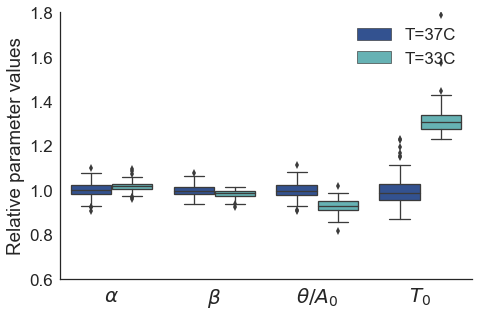

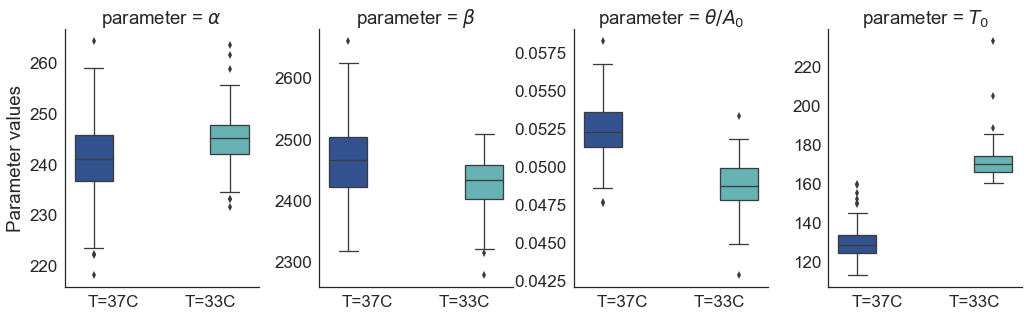

In [6]:
# plotting parameters values and the relationship between T=37 and 33C
p_names = [r'$\alpha$', r'$\beta$', r'$\theta/A_0$', r'$T_0$']
plotf.parameter_values(x37, x33, p, params, p_names, label=['T=37C', 'T=33C'], relative_values=True, 
                       ylim=[0.6, 1.8])
plotf.parameter_values(x37, x33, p, params, p_names, label=['T=37C', 'T=33C'], relative_values=False,
                       aspect=0.8)

In [7]:
print 'Average parameter values for T=37C:'
for i in range(len(params)):
    print params[i], np.mean(x37, axis=0)[i]*p[params[i]], np.std(x37, axis=0)[i]*p[params[i]]
print ''

print 'Average parameter values for  T=33C:'
for i in range(len(params)):
    print params[i], np.mean(x33, axis=0)[i]*p[params[i]], np.std(x33, axis=0)[i]*p[params[i]]

Average parameter values for T=37C:
a 240.8516258135954 8.040694721558662
b 2470.431324801153 66.0065156537973
theta 0.052404349766682984 0.0018877082816345413
T0 130.00601868819982 8.542203675701156

Average parameter values for  T=33C:
a 245.11154388322083 5.391171003506971
b 2427.4724899329685 42.881373364646954
theta 0.048737137194326034 0.0014954404219721064
T0 171.10876139693798 8.943076092144462


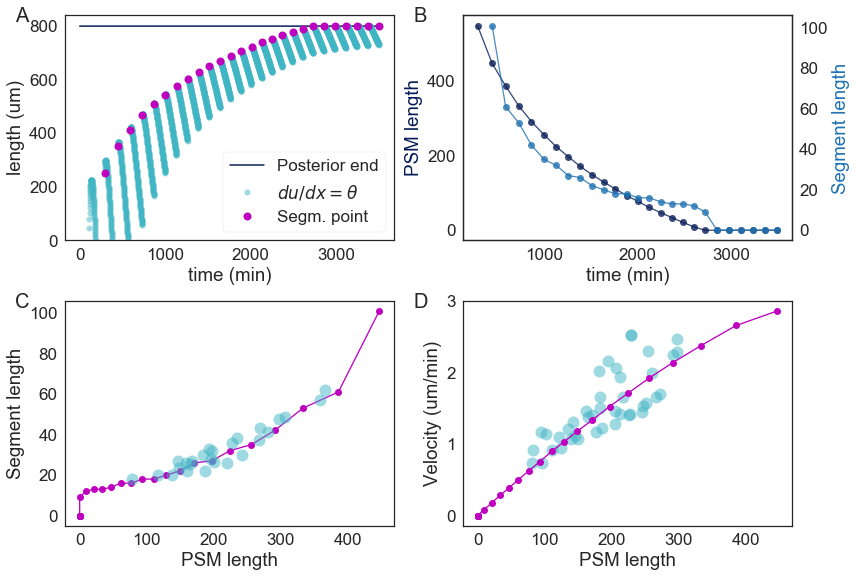

In [8]:
p = {}
p['a']  = 237.0
p['b']  = 2460.0
p['theta'] = 0.053
p['L0'] = 800.0
p['tr'] = np.arange(0, 3501, 1)

p['T0'] = 130.
plotf.exvivo_segmentation(d37, p)
# plotf.exvivo_segmentation(d33, p)

### Plotting the relationship between the spatial phase-difference and comparing to experimental data

/Users/marcelob/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/Users/marcelob/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in divide


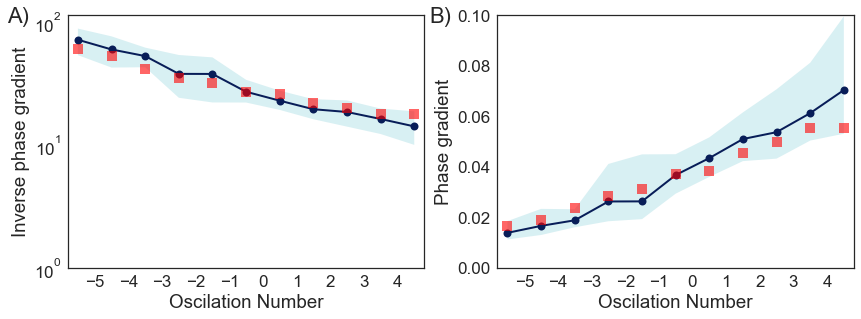

In [18]:
cmap = plt.cm.YlGnBu
D = pd.read_csv('./experimental_data/Lauschke_data/Fig4b_complete.csv' , index_col=None, header=0)

xs  = modelf.xsegment(d37, p, case='ex-vivo')                            
ixs = modelf.ixsegment(xs, case='ex-vivo')    
lxs = xs[ixs,1][1:] - xs[ixs,1][:-1]
T = xs[ixs,0][1:] - xs[ixs,0][:-1]
psm = p['L0']-xs[ixs,1]
dpsm = psm[:-1] - psm[1:]

fig = plt.subplots(1, 2, figsize=(2*6.0, 4.5), sharey=False)
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax1.text(-.17, 0.97, 'A)',transform=ax1.transAxes, size=22)
ax1.plot(D['OscNumber'],D['Mean'],'o-', ms=8, lw=2.0, c=cmap(1.0))
ax1.fill_between(D['OscNumber'], D['Stdlow'], D['Stdhigh'], alpha=0.2, facecolor=cmap(0.5))      
ax1.plot(np.arange(0, len(dpsm))-6.5, 1.0/(1/dpsm), 'rs', ms=10, alpha=0.6)
ax1.set_yscale('log')
ax1.set_yticks([1, 10, 100])
ax1.set_xticks(np.arange(-5, 5, 1))
ax1.set_xlim([-5.8, 4.8])
ax1.set_ylabel('Inverse phase gradient')
ax1.set_xlabel('Oscilation Number')

ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
ax2.text(-.19, 0.97, 'B)',transform=ax2.transAxes, size=22)
ax2.plot(D['OscNumber'], 1./D['Mean'], 'o-', ms=8, lw=2.0, c=cmap(1.0))
ax2.fill_between(D['OscNumber'], 1./D['Stdlow'], 1./D['Stdhigh'], alpha=0.2, facecolor=cmap(0.5))      
ax2.plot(np.arange(0, len(dpsm))-6.5, (1/dpsm), 'rs', ms=10, alpha=0.6)
ax2.set_xticks(np.arange(-5, 5, 1))
ax2.set_xlim([-5.8, 4.8])
ax2.set_ylim([0, 0.1])
ax2.set_ylabel('Phase gradient')
ax2.set_xlabel('Oscilation Number')
plt.tight_layout()
# plt.savefig('./PeriodGradientLauschke.pdf')